## MLFlow register' from Clusterization with Boston Safety Data


The Boston Safety Data is an open dataset from Azure Open Datasets.

This dataset records all calls made to 311 services, which are non-emergency calls regarding various issues in the city. Our goal is to use machine learning clustering to gain new insights by grouping the data into clusters.

In this notebook, we will analyze the evolution of clustering models focusing on their performance, accuracy and effiency.
More than 100 models were tested through extensive experimentation, including K-Means, BisectingKMeans and Gaussian Mixture.


In [1]:
# Imports
import mlflow
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pyspark.sql.functions import col, count, when, format_number # To building and format the dataframes
from pyspark.sql import Row

# para executar o indexer e o onehotencoder:

from pyspark.ml.feature import OneHotEncoder, StringIndexer

#clustering

from pyspark.ml.clustering import KMeans, BisectingKMeans, GaussianMixture
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from datetime import datetime

warnings.filterwarnings('ignore')

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 3, Finished, Available, Finished)

In [2]:
# Listing the created experiments
# Listando os experimentos criados
experiments = mlflow.search_experiments()
for exp in experiments:
   print(exp.name)

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 4, Finished, Available, Finished)

Notebook-1
Clusterização_Boston
Boston_Safety_Data_notebook
Boston_Safety_Data_notebook-2
Boston_Safety_Data_notebook_3


In [3]:
experiment_name1 = "Notebook-1"
experiment_name2 = "Boston_Safety_Data_notebook"
experiment_name3 = "Boston_Safety_Data_notebook-2"
experiment_name4 = "Boston_Safety_Data_notebook-3"

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 5, Finished, Available, Finished)

### Checking the First Experiment

In [4]:
# Print experiment details
# Imprime detalhes do experimento
experiment_name = "Boston_Safety_Data_notebook_3"
exp = mlflow.get_experiment_by_name(experiment_name)
print(exp)

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 6, Finished, Available, Finished)

<Experiment: artifact_location='', creation_time=1749219307504, experiment_id='14bbf908-b9cd-4253-b201-ac2ad9fa1da4', last_update_time=None, lifecycle_stage='active', name='Boston_Safety_Data_notebook_3', tags={}>


In [5]:
# Listing what was performed in the experiment
# Listando o que foi executado no experimento
mlflow.search_runs(exp.experiment_id)


StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 7, Finished, Available, Finished)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.davies_bouldin_score,metrics.silhouette_score,params.numero_de_clusters,params.modelo,params.algoritmo,tags.synapseml.notebook.artifactId,tags.mlflow.autologging,tags.synapseml.run.artifactJobId,tags.mlflow.user,tags.mlflow.rootRunId,tags.mlflow.runName,tags.synapseml.livy.id,tags.synapseml.user.name,tags.synapseml.user.id
0,bd0d10ce-5aff-4408-ac10-87aaed52ff56,14bbf908-b9cd-4253-b201-ac2ad9fa1da4,FINISHED,sds://onelakebrazilsouth.pbidedicated.windows....,2025-06-06 14:15:13.148000+00:00,2025-06-06 14:15:23.053000+00:00,NaN,NaN,None,None,None,897db207-6500-4929-952f-077bcac7d6f9,pyspark.ml,fccf2a93-71f0-4bf7-9c25-41ff7d5817fd,4b3a56ea-6f42-450e-b7c3-fb2932c7ac32,bd0d10ce-5aff-4408-ac10-87aaed52ff56,clever_horse_5ckt5t4m,c3d1286c-c8f2-454e-a272-376e83a361a0,RENATA DE CASSIA THOMAZELLI,5df9b0db-d28a-4687-9cfd-515d8d31cdc7
1,26d676af-7bc7-4fac-ac4c-ae082be6e08a,14bbf908-b9cd-4253-b201-ac2ad9fa1da4,FINISHED,sds://onelakebrazilsouth.pbidedicated.windows....,2025-06-06 14:15:24.607000+00:00,2025-06-06 14:15:32.019000+00:00,NaN,NaN,None,None,None,897db207-6500-4929-952f-077bcac7d6f9,pyspark.ml,cc575f63-20eb-4bb9-a3da-d468df3d4da8,4b3a56ea-6f42-450e-b7c3-fb2932c7ac32,26d676af-7bc7-4fac-ac4c-ae082be6e08a,tidy_cheetah_k2vbfstc,c3d1286c-c8f2-454e-a272-376e83a361a0,RENATA DE CASSIA THOMAZELLI,5df9b0db-d28a-4687-9cfd-515d8d31cdc7
2,b533e5ab-3efa-4c55-a5a6-574dfc446137,14bbf908-b9cd-4253-b201-ac2ad9fa1da4,FINISHED,sds://onelakebrazilsouth.pbidedicated.windows....,2025-06-06 14:15:33.376000+00:00,2025-06-06 14:15:41.471000+00:00,NaN,NaN,None,None,None,897db207-6500-4929-952f-077bcac7d6f9,pyspark.ml,170912d8-9593-421a-a6e1-454a5f419480,4b3a56ea-6f42-450e-b7c3-fb2932c7ac32,b533e5ab-3efa-4c55-a5a6-574dfc446137,plum_key_f94ljx71,c3d1286c-c8f2-454e-a272-376e83a361a0,RENATA DE CASSIA THOMAZELLI,5df9b0db-d28a-4687-9cfd-515d8d31cdc7
3,f602ae1e-9a82-4fa8-8205-9cf95024828d,14bbf908-b9cd-4253-b201-ac2ad9fa1da4,FINISHED,sds://onelakebrazilsouth.pbidedicated.windows....,2025-06-06 14:15:42.461000+00:00,2025-06-06 14:15:43.113000+00:00,NaN,NaN,None,None,None,897db207-6500-4929-952f-077bcac7d6f9,pyspark.ml,c8da4e83-ca8f-471f-b190-4016afdc06c8,4b3a56ea-6f42-450e-b7c3-fb2932c7ac32,f602ae1e-9a82-4fa8-8205-9cf95024828d,maroon_guava_z2q7tg5c,c3d1286c-c8f2-454e-a272-376e83a361a0,RENATA DE CASSIA THOMAZELLI,5df9b0db-d28a-4687-9cfd-515d8d31cdc7
4,cb6ad091-b3bc-4298-a1fc-16edf49ef4e3,14bbf908-b9cd-4253-b201-ac2ad9fa1da4,FINISHED,sds://onelakebrazilsouth.pbidedicated.windows....,2025-06-06 14:15:44.398000+00:00,2025-06-06 14:15:45.018000+00:00,NaN,NaN,None,None,None,897db207-6500-4929-952f-077bcac7d6f9,pyspark.ml,5f518f31-d76e-4dd5-9520-dcb23bae96d8,4b3a56ea-6f42-450e-b7c3-fb2932c7ac32,cb6ad091-b3bc-4298-a1fc-16edf49ef4e3,plucky_fig_8xm43bpq,c3d1286c-c8f2-454e-a272-376e83a361a0,RENATA DE CASSIA THOMAZELLI,5df9b0db-d28a-4687-9cfd-515d8d31cdc7
5,10abb281-61f2-4fee-935f-e00b38e5796e,14bbf908-b9cd-4253-b201-ac2ad9fa1da4,FINISHED,sds://onelakebrazilsouth.pbidedicated.windows....,2025-06-06 14:15:46.232000+00:00,2025-06-06 14:15:46.803000+00:00,NaN,NaN,None,None,None,897db207-6500-4929-952f-077bcac7d6f9,pyspark.ml,b1bf025c-ca6a-4f6b-9583-632bc24a89fc,4b3a56ea-6f42-450e-b7c3-fb2932c7ac32,10abb281-61f2-4fee-935f-e00b38e5796e,silly_cabbage_sg8d2v2k,c3d1286c-c8f2-454e-a272-376e83a361a0,RENATA DE CASSIA THOMAZELLI,5df9b0db-d28a-4687-9cfd-515d8d31cdc7
6,3aab1252-c687-4377-a794-633ecf643a2e,14bbf908-b9cd-4253-b201-ac2ad9fa1da4,FINISHED,sds://onelakebrazilsouth.pbidedicated.windows....,2025-06-06 14:16:20.955000+00:00,2025-06-06 14:16:28.904000+00:00,NaN,NaN,None,None,None,897db207-6500-4929-952f-077bcac7d6f9,pyspark.ml,6f4885d8-d035-488e-89d2-b4f5f55e4e46,4b3a56ea-6f42-450e-b7c3-fb2932c7ac32,3aab1252-c687-4377-a794-633ecf643a2e,ashy_night_0hd89q5p,c3d1286c-c8f2-454e-a272-376e83a361a0,RENATA DE CASSIA THOMAZELLI,5df9b0db-d28a-4687-9cfd-515d8d31cdc7
7,b3002f09-423d-4eba-a596-dbd6a1973916,14bbf908-b9cd-4253-b201-

In [6]:
df_results = mlflow.search_runs(exp.experiment_id)

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 8, Finished, Available, Finished)

In [7]:
# Listing all available columns to check correct metric names
# Listando todas as colunas disponíveis para verificar os nomes corretos das métricas
df_results = mlflow.search_runs(exp.experiment_id, order_by = ["start_time DESC"])
print("Colunas disponíveis:", df_results.columns)

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 9, Finished, Available, Finished)

Colunas disponíveis: Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.davies_bouldin_score', 'metrics.silhouette_score',
       'params.numero_de_clusters', 'params.modelo', 'params.algoritmo',
       'tags.synapseml.notebook.artifactId',
       'tags.synapseml.run.artifactJobId', 'tags.mlflow.user',
       'tags.mlflow.rootRunId', 'tags.mlflow.runName',
       'tags.synapseml.livy.id', 'tags.synapseml.user.name',
       'tags.synapseml.user.id', 'tags.mlflow.autologging'],
      dtype='object')


In [8]:
# Selecting metrics and names
# Selecionando métricas e nomes .
df_results_metrics = df_results[["run_id", "tags.mlflow.runName", "metrics.silhouette_score", "metrics.davies_bouldin_score", "params.modelo"]]




StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 10, Finished, Available, Finished)

In [9]:
df_results_metrics

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 11, Finished, Available, Finished)

,run_id,tags.mlflow.runName,metrics.silhouette_score,metrics.davies_bouldin_score,params.modelo
0,ba258d32-38f1-49c7-b9c8-a0a61c4ee7ad,Clusterizacao_BisectingKMeans,0.917107,0.113713,modelo_bisecting_kmeans
1,09ed3d90-9f59-4020-8c9f-b6e3d779e8fa,modest_tangelo_gts3l5mc,NaN,NaN,None
2,da3d309d-55e7-4a86-9307-d238e7d5bac4,Clusterizacao_K-Means,0.934305,0.424636,modelo_kmeans
3,32a4b894-3a81-4f45-a7db-362c1e860718,silly_plastic_xldk1fmp,NaN,NaN,None
4,fc322a52-341c-4098-a2f6-43c328d3f4ec,Clusterizacao_GaussianMixture,0.561102,1.003357,modelo_gaussianmixture
5,afbe3b57-217b-4767-b823-b2905bcc46e4,maroon_truck_vf754njz,NaN,NaN,None
6,b35b7aea-c6da-42c9-953f-bbfe755cb3c0,jolly_tray_m9w1yf01,NaN,NaN,None
7,859b20f4-508c-43fd-a656-3dbb5c9fc021,coral_melon_k96zcrwd,NaN,NaN,None
8,5e967bff-f0a2-43fc-8f26-3cda85a38ccc,heroic_tangelo_5cmg5prj,NaN,NaN,None
9,d1dab0b9-9949-470c-9b8a-9827a480fc1d,tidy_rhythm_2px744nn,NaN,NaN,None


In [10]:

print(type(df_results_metrics))


StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 12, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>


In [11]:

df_results_metrics_filtered = df_results_metrics[df_results_metrics["params.modelo"].isin(["modelo_bisecting_kmeans", "modelo_kmeans", "modelo_gaussianmixture"])]


StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 13, Finished, Available, Finished)

In [12]:
df_results_metrics_filtered

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 14, Finished, Available, Finished)

,run_id,tags.mlflow.runName,metrics.silhouette_score,metrics.davies_bouldin_score,params.modelo
0,ba258d32-38f1-49c7-b9c8-a0a61c4ee7ad,Clusterizacao_BisectingKMeans,0.917107,0.113713,modelo_bisecting_kmeans
2,da3d309d-55e7-4a86-9307-d238e7d5bac4,Clusterizacao_K-Means,0.934305,0.424636,modelo_kmeans
4,fc322a52-341c-4098-a2f6-43c328d3f4ec,Clusterizacao_GaussianMixture,0.561102,1.003357,modelo_gaussianmixture


In [13]:

# Converter para PySpark DataFrame
df_spark_results_metrics = spark.createDataFrame(df_results_metrics)

# Agora pode salvar como tabela no Spark
df_spark_results_metrics.write.mode("overwrite").saveAsTable("df_spark_results_metrics_jun06")

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 15, Finished, Available, Finished)

In [14]:
import mlflow
import pandas as pd

# List of experiment names
# Lista de nomes dos experimentos
experiment_names = [
   
    "Boston_Safety_Data_notebook",
    "Boston_Safety_Data_notebook-2",
    "Boston_Safety_Data_notebook_3"
]

# List to store the filtered dataframes
# Lista para armazenar os dataframes filtrados
dataframes_list = []

# Loop to process each experiment
# Loop para processar cada experimento
for experiment_name in experiment_names:

    # Get the experiment by name
    # Obter o experimento pelo nome
    exp = mlflow.get_experiment_by_name(experiment_name)
    
    if exp:

        # Search for experiment runs
        # Buscar as execuções do experimento
        df_results = mlflow.search_runs(exp.experiment_id)
        
        # Select the desired columns
        # Selecionar as colunas desejadas
        df_results_metrics = df_results[["start_time","end_time","run_id", "tags.mlflow.runName","params.numero_de_clusters","metrics.silhouette_score", "metrics.davies_bouldin_score", "params.modelo"]]
        
        # Filter the data to include only the desired models
        # Filtrar os dados para incluir apenas os modelos desejados
        df_results_metrics_filtered = df_results_metrics[df_results_metrics["params.modelo"].isin(["modelo_bisecting_kmeans", "modelo_kmeans", "modelo_gaussianmixture"])]
        
        # Add the column with the experiment name
        # Adicionar a coluna com o nome do experimento
        df_results_metrics_filtered["experiment_name"] = experiment_name
        
        # Add the filtered dataframe to the list
        # Adicionar o dataframe filtrado à lista
        dataframes_list.append(df_results_metrics_filtered)
    else:
        print(f"Experimento '{experiment_name}' não encontrado.")

# Concatenate all dataframes into a single dataframe
# Concatenar todos os dataframes em um único dataframe
df_concatenated = pd.concat(dataframes_list, ignore_index=True)

# View the concatenated dataframe
# Visualizar o dataframe concatenado
df_concatenated


StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 16, Finished, Available, Finished)

,start_time,end_time,run_id,tags.mlflow.runName,params.numero_de_clusters,metrics.silhouette_score,metrics.davies_bouldin_score,params.modelo,experiment_name
0,2025-05-28 14:07:03.649000+00:00,2025-05-28 14:08:20.523000+00:00,eb2501b1-8675-4280-9184-bbca7be994fe,Clusterizacao_K-Means,None,NaN,NaN,modelo_kmeans,Boston_Safety_Data_notebook
1,2025-05-28 16:01:33.130000+00:00,2025-05-28 16:43:28.887000+00:00,f635a708-07b7-4b89-8ba8-1eb850fac97d,Clusterizacao_K-Means,None,NaN,NaN,modelo_kmeans,Boston_Safety_Data_notebook
2,2025-05-28 16:46:06.604000+00:00,2025-05-28 16:54:39.680000+00:00,8d128896-5a37-4632-85c3-9738ef8bc3be,Clusterizacao_K-Means,5,0.476224,1.293134,modelo_kmeans,Boston_Safety_Data_notebook
3,2025-05-28 17:01:40.195000+00:00,2025-05-28 17:09:47.145000+00:00,cfdd007b-4c99-4550-ad7b-10cb8b8c8282,Clusterizacao_K-Means,5,0.476224,1.293134,modelo_kmeans,Boston_Safety_Data_notebook
4,2025-05-28 17:22:52.693000+00:00,2025-05-28 17:31:08.182000+00:00,ed801dd6-f1a2-40d1-b768-3fd17571a2e4,Clusterizacao_K-Means,5,0.476224,1.293134,modelo_kmeans,Boston_Safety_Data_notebook
...,...,...,...,...,...,...,...,...,...
100,2025-06-04 13:21:02.038000+00:00,2025-06-04 13:22:23.122000+00:00,1828cd90-2a52-46da-8a90-cd4cfbf65b1f,Clusterizacao_K-Means,5,0.934402,0.428211,modelo_kmeans,Boston_Safety_Data_notebook-2
101,2025-06-04 13:22:33.926000+00:00,2025-06-04 13:24:21.118000+00:00,830fa831-4bc1-47d8-89f0-e74f16f68e68,Clusterizacao_BisectingKMeans,5,0.918987,0.113107,modelo_bisecting_kmeans,Boston_Safety_Data_notebook-2
102,2025-06-06 14:17:19.247000+00:00,2025-06-06 14:18:51.418000+00:00,fc322a52-341c-4098-a2f6-43c328d3f4ec,Clusterizacao_GaussianMixture,5,0.561102,1.003357,modelo_gaussianmixture,Boston_Safety_Data_notebook_3
103,2025-06-06 14:19:04.749000+00:00,2025-06-06 14:20:11.101000+00:00,da3d309d-55e7-4a86-9307-d238e7d5bac4,Clusterizacao_K-Means,5,0.934305,0.424636,modelo_kmeans,Boston_Safety_Data_notebook_3


In [15]:

df_concatenated_sorted = df_concatenated.sort_values(by=["metrics.silhouette_score", "metrics.davies_bouldin_score"], ascending=[False, True])


StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 17, Finished, Available, Finished)

In [16]:
df_concatenated_sorted.head()

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 18, Finished, Available, Finished)

,start_time,end_time,run_id,tags.mlflow.runName,params.numero_de_clusters,metrics.silhouette_score,metrics.davies_bouldin_score,params.modelo,experiment_name
100,2025-06-04 13:21:02.038000+00:00,2025-06-04 13:22:23.122000+00:00,1828cd90-2a52-46da-8a90-cd4cfbf65b1f,Clusterizacao_K-Means,5,0.934402,0.428211,modelo_kmeans,Boston_Safety_Data_notebook-2
103,2025-06-06 14:19:04.749000+00:00,2025-06-06 14:20:11.101000+00:00,da3d309d-55e7-4a86-9307-d238e7d5bac4,Clusterizacao_K-Means,5,0.934305,0.424636,modelo_kmeans,Boston_Safety_Data_notebook_3
48,2025-06-02 12:58:06.952000+00:00,2025-06-02 12:59:59.227000+00:00,31964a88-c5bf-41f6-b522-68ac32d7b953,Clusterizacao_K-Means,4,0.933178,0.073341,modelo_kmeans,Boston_Safety_Data_notebook
49,2025-06-02 13:00:02.576000+00:00,2025-06-02 13:01:47.602000+00:00,2022b6f7-984f-46ff-a679-69dd40f0c637,Clusterizacao_BisectingKMeans,4,0.933178,0.073341,modelo_bisecting_kmeans,Boston_Safety_Data_notebook
99,2025-06-04 13:19:42.762000+00:00,2025-06-04 13:20:48.461000+00:00,d36946bc-a0d4-45ad-957d-32b380c5956c,Clusterizacao_GaussianMixture,5,0.930368,0.415896,modelo_gaussianmixture,Boston_Safety_Data_notebook-2


In [17]:
# Converter para PySpark DataFrame
df_spark_experiments_concatenated = spark.createDataFrame(df_concatenated_sorted)

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 19, Finished, Available, Finished)

In [18]:
display(df_spark_experiments_concatenated)

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 20, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 79af4fa7-f047-4ee7-98ff-4d41c3b86265)

In [19]:
type(df_spark_experiments_concatenated)

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 21, Finished, Available, Finished)

pyspark.sql.dataframe.DataFrame

In [20]:
df_spark_experiments_concatenated.show(10,truncate=False)

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 22, Finished, Available, Finished)

+-----------------------+-----------------------+------------------------------------+-----------------------------+-------------------------+------------------------+----------------------------+-----------------------+-----------------------------+
|start_time             |end_time               |run_id                              |tags.mlflow.runName          |params.numero_de_clusters|metrics.silhouette_score|metrics.davies_bouldin_score|params.modelo          |experiment_name              |
+-----------------------+-----------------------+------------------------------------+-----------------------------+-------------------------+------------------------+----------------------------+-----------------------+-----------------------------+
|2025-06-04 13:21:02.038|2025-06-04 13:22:23.122|1828cd90-2a52-46da-8a90-cd4cfbf65b1f|Clusterizacao_K-Means        |5                        |0.9344019681287432      |0.42821065319206975         |modelo_kmeans          |Boston_Safety_Data_notebook

In [21]:
df_concatenated_sorted.info()

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 23, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 100 to 94
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   start_time                    105 non-null    datetime64[ns, UTC]
 1   end_time                      105 non-null    datetime64[ns, UTC]
 2   run_id                        105 non-null    object             
 3   tags.mlflow.runName           105 non-null    object             
 4   params.numero_de_clusters     99 non-null     object             
 5   metrics.silhouette_score      99 non-null     float64            
 6   metrics.davies_bouldin_score  99 non-null     float64            
 7   params.modelo                 105 non-null    object             
 8   experiment_name               105 non-null    object             
dtypes: datetime64[ns, UTC](2), float64(2), object(5)
memory usage: 8.2+ KB


In [22]:
# Including a new column to duration
# criando uma nova coluna como duração
df_concatenated_sorted['start_time'] = pd.to_datetime(df_concatenated_sorted['start_time'])
df_concatenated_sorted['end_time'] = pd.to_datetime(df_concatenated_sorted['end_time'])

# Calculate the difference between end_time and start_time, considering only the time part
# Calcular a diferença entre end_time e start_time, considerando apenas a parte do tempo
df_concatenated_sorted['duration'] = (df_concatenated_sorted['end_time'] - df_concatenated_sorted['start_time']).dt.total_seconds() 

# Show the DataFrame whith the new duration column
# Exibir o DataFrame com a nova coluna
df_concatenated_sorted


StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 24, Finished, Available, Finished)

,start_time,end_time,run_id,tags.mlflow.runName,params.numero_de_clusters,metrics.silhouette_score,metrics.davies_bouldin_score,params.modelo,experiment_name,duration
100,2025-06-04 13:21:02.038000+00:00,2025-06-04 13:22:23.122000+00:00,1828cd90-2a52-46da-8a90-cd4cfbf65b1f,Clusterizacao_K-Means,5,0.934402,0.428211,modelo_kmeans,Boston_Safety_Data_notebook-2,81.084
103,2025-06-06 14:19:04.749000+00:00,2025-06-06 14:20:11.101000+00:00,da3d309d-55e7-4a86-9307-d238e7d5bac4,Clusterizacao_K-Means,5,0.934305,0.424636,modelo_kmeans,Boston_Safety_Data_notebook_3,66.352
48,2025-06-02 12:58:06.952000+00:00,2025-06-02 12:59:59.227000+00:00,31964a88-c5bf-41f6-b522-68ac32d7b953,Clusterizacao_K-Means,4,0.933178,0.073341,modelo_kmeans,Boston_Safety_Data_notebook,112.275
49,2025-06-02 13:00:02.576000+00:00,2025-06-02 13:01:47.602000+00:00,2022b6f7-984f-46ff-a679-69dd40f0c637,Clusterizacao_BisectingKMeans,4,0.933178,0.073341,modelo_bisecting_kmeans,Boston_Safety_Data_notebook,105.026
99,2025-06-04 13:19:42.762000+00:00,2025-06-04 13:20:48.461000+00:00,d36946bc-a0d4-45ad-957d-32b380c5956c,Clusterizacao_GaussianMixture,5,0.930368,0.415896,modelo_gaussianmixture,Boston_Safety_Data_notebook-2,65.699
...,...,...,...,...,...,...,...,...,...,...
1,2025-05-28 16:01:33.130000+00:00,2025-05-28 16:43:28.887000+00:00,f635a708-07b7-4b89-8ba8-1eb850fac97d,Clusterizacao_K-Means,None,NaN,NaN,modelo_kmeans,Boston_Safety_Data_notebook,2515.757
26,2025-06-01 20:49:13.420000+00:00,2025-06-01 20:50:01.940000+00:00,5f2f3bb8-7bfb-4f7d-9adc-602a6c746e90,Clusterizacao_GaussianMixture,None,NaN,NaN,modelo_gaussianmixture,Boston_Safety_Data_notebook,48.520
42,2025-06-01 22:12:33.077000+00:00,2025-06-01 22:13:41.525000+00:00,d271469b-c763-46d9-a003-c2b0595604a3,Clusterizacao_BisectingKMeans,None,NaN,NaN,modelo_bisecting_kmeans,Boston_Safety_Data_notebook,68.448
83,2025-06-02 22:40:04.505000+00:00,2025-06-02 22:41:27.763000+00:00,52d53cfe-f8af-4c41-9020-65a368ac6301,Clusterizacao_BisectingKMeans,None,NaN,NaN,modelo_bisecting_kmeans,Boston_Safety_Data_notebook,83.258


StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 25, Finished, Available, Finished)

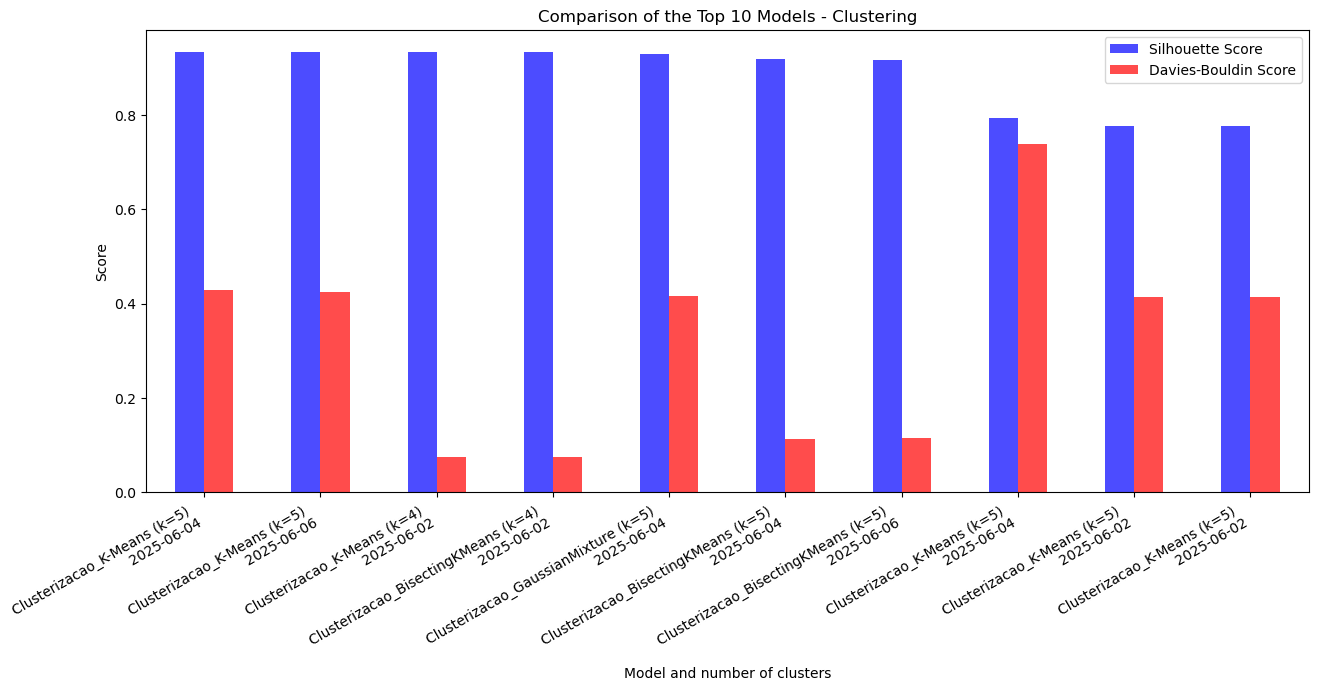

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Criar DataFrame com os melhores resultados


df = pd.DataFrame(df_concatenated_sorted)
df = df.head(10)

# Converter a coluna de data para string formatada (YYYY-MM-DD)
df["start_time"] = df["start_time"].dt.strftime("%Y-%m-%d")


df["x_label"] = df["tags.mlflow.runName"] + " (k=" + df["params.numero_de_clusters"].astype(str) + ") \n " + df["start_time"]


# Criar gráfico de barras comparando os scores
fig, ax = plt.subplots(figsize=(15, 6))

df.plot(x="x_label", y=["metrics.silhouette_score", "metrics.davies_bouldin_score"], kind="bar", ax=ax, color=["blue", "red"], alpha=0.7)

plt.xlabel("Model and number of clusters")
plt.ylabel("Score")
plt.title("Comparison of the Top 10 Models - Clustering")
plt.legend(["Silhouette Score", "Davies-Bouldin Score"])
plt.xticks(rotation=30, ha="right")

plt.show()

StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 26, Finished, Available, Finished)

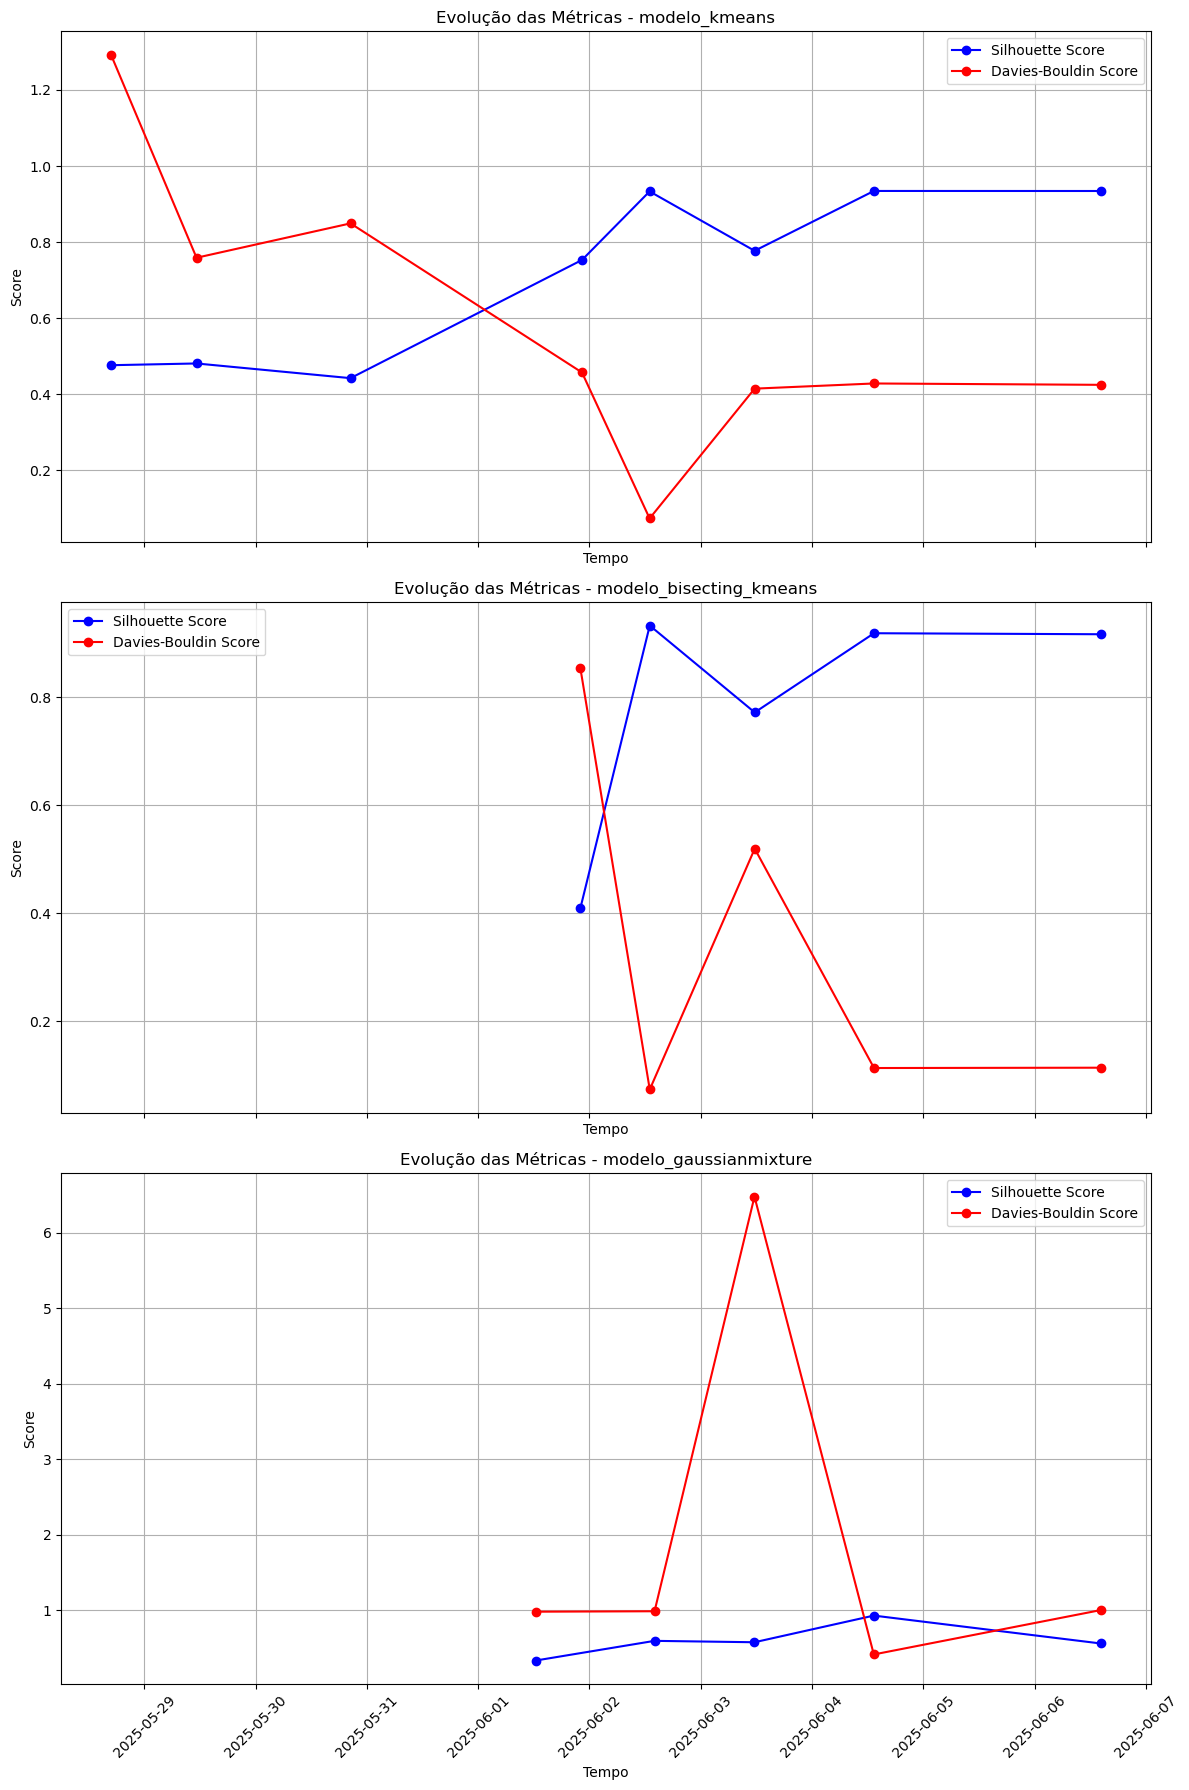

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert time column to datetime
# Converter a coluna de tempo para datetime
df_sorted = df_concatenated_sorted.copy()
df_sorted["start_time"] = pd.to_datetime(df_sorted["start_time"])
df_sorted["date"] = df_sorted["start_time"].dt.date  # Criando coluna apenas com a data

# Filter the best result by day (highest Silhouette Score)
# Filtrar o melhor resultado por dia (maior Silhouette Score)
df_filtered = df_sorted.loc[df_sorted.groupby(["date", "params.modelo"])["metrics.silhouette_score"].idxmax()]

# Identify unique models
# Identificar os modelos únicos
modelos_unicos = df_sorted["params.modelo"].unique()

# Create multiple graphs, one for each model
# Criar múltiplos gráficos, um para cada modelo
fig, axes = plt.subplots(nrows=len(modelos_unicos), figsize=(12, 6 * len(modelos_unicos)), sharex=True)

for i, modelo in enumerate(modelos_unicos):
    ax = axes[i]
    
    # Filter specific model data
    # Filtrar dados do modelo específico
    df_modelo = df_filtered[df_filtered["params.modelo"] == modelo].sort_values(by="start_time")
    
    # Create line chart
    # Criar gráfico de linha
    ax.plot(df_modelo["start_time"], df_modelo["metrics.silhouette_score"], marker='o', linestyle='-', label="Silhouette Score", color='blue')
    ax.plot(df_modelo["start_time"], df_modelo["metrics.davies_bouldin_score"], marker='o', linestyle='-', label="Davies-Bouldin Score", color='red')
    
    ax.set_title(f"Evolução das Métricas - {modelo}")
    ax.set_xlabel("Tempo")
    ax.set_ylabel("Score")
    ax.legend()
    ax.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


StatementMeta(, 995dbf9d-d60d-46ff-afbd-1d74c0910429, 27, Finished, Available, Finished)

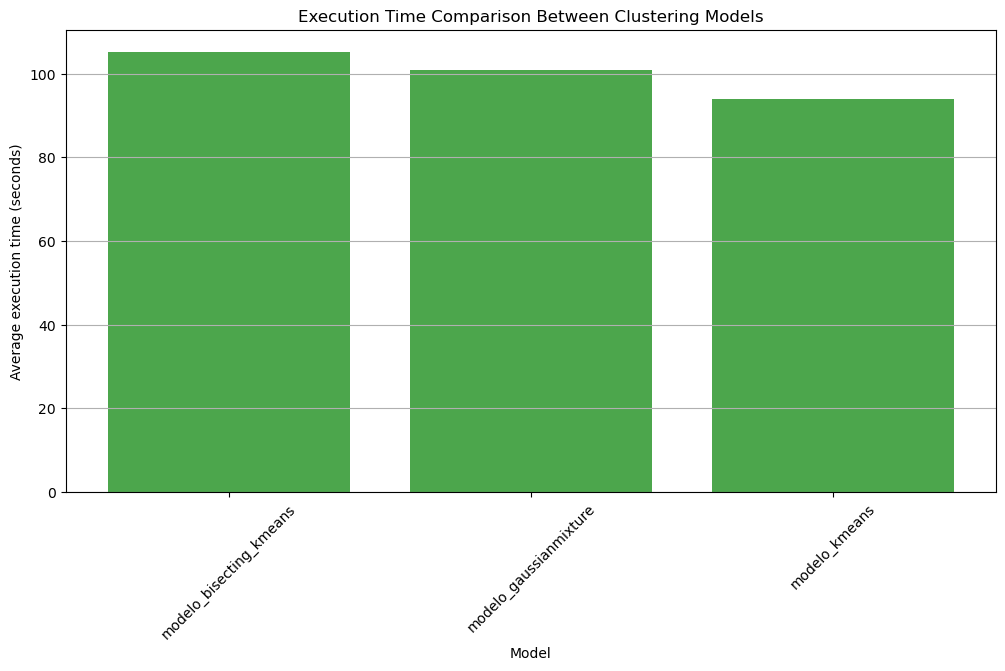

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Criar DataFrame com os dados
df_sorted_jun01 = df_concatenated_sorted[df_concatenated_sorted['start_time']>=pd.Timestamp('2025-06-01',tz='UTC')].copy()

# Converter duration para formato numérico 
df_sorted_jun01["duration"] = pd.to_numeric(df_sorted_jun01["duration"], errors="coerce")

# Calcular média de duração por modelo
df_avg_duration = df_sorted_jun01.groupby("params.modelo")["duration"].mean().reset_index()

# Criar gráfico de barras para comparar tempos de execução
plt.figure(figsize=(12, 6))
plt.bar(df_avg_duration["params.modelo"], df_avg_duration["duration"], color="green", alpha=0.7)

plt.xlabel("Model")
plt.ylabel("Average execution time (seconds)")
plt.title("Execution Time Comparison Between Clustering Models")
plt.xticks(rotation=45)
plt.grid(axis="y")

plt.show()